# Let's Train GPT-2



### Install Packages


In [1]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout dev && git pull
    !pip install tiktoken --quiet
    !pip uninstall -y tensorflow

In [2]:
from pathlib import Path
import sys

if is_colab():
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )

sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/Users/vikram/dev/jaxpt/src


In [3]:
import jax
import optax
import jax.numpy as jnp
import numpy as np
from flax import nnx
import tiktoken

from jaxpt.dataloaders import DataLoader
from jaxpt.models import GPT2, GPTConfig
from jaxpt.train import train_step, parallel_train_step, accum_train_step, loss_fn, compute_global_norm
from jaxpt.infer import generate

### Configure compute

In [4]:
import os

# Hardware setup
print("JAX version:", jax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

jax.config.update("jax_platform_name", "gpu") # Make sure we're using the GPU
#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
jax.config.update("jax_default_matmul_precision", "bfloat16") # Set the default precision for matrix multiplication

os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

def list_tpu_memory():
    devices = jax.devices()
    for device in devices:
        if 'TPU' in str(device.device_kind):
            print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

#list_tpu_memory()

print("Using device:", jax.default_backend())  # Should print 'gpu'

A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Makes sure the matmul is fast

#%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Available devices: 1
Using device: cpu


### Initialize the GPT-2 model and perform a sanity check

In [5]:
from functools import partial

import orbax.checkpoint as ocp

"""
+--------------+---------+--------+------+
| Model        | Layers  | Heads  | Embd |
+--------------+---------+--------+------+
| gpt2-medium  | 24      | 16     | 1024 |
| gpt2-large   | 36      | 20     | 1280 |
| gpt2-xl      | 48      | 25     | 1600 |
+--------------+---------+--------+------+
"""
from datetime import datetime
import random
import string

def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()
run_dir = f"run_{timestamp}_{random_code}"
print(run_dir)


checkpoint_dir = Path().absolute().parent / "checkpoints" 
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

log_dir = Path().absolute().parent / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, step):
  checkpoint_path = checkpoint_dir / run_dir / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(run_dir, step):
  checkpoint_path = checkpoint_dir / run_dir / f"checkpoint-{step}.pt"
  m = GPT2.from_checkpoint(checkpoint_path, rngs)
  return m


key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)
config = GPTConfig(dtype=jnp.float32)
m = GPT2(config, rngs)
#m = load_checkpoint("run_20250310_krcksm", 199)
graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
nnx.display(state)

def generate_completions():
  m.eval()
  num_completions = 5
  max_length = 20
  generate_completion = partial(generate, m, max_length=max_length)
  prefix = "The clever jackal"
  enc = tiktoken.get_encoding('gpt2')
  tokens = enc.encode(prefix)
  tokens = jnp.array(tokens, dtype=jnp.int32)
  tokens = jnp.expand_dims(tokens, axis=0)
  x = jnp.tile(tokens, (num_completions, 1))


  x = generate_completion(x=x) # Make sure you can do a forward pass
  output = []
  for i in range(num_completions):
      tokens = x[i, :max_length].tolist()
      decoded = enc.decode(tokens)
      output.append(decoded)
  return output

completions = generate_completions()
for completion in completions:
  print(completion)


run_20250310_yffvuj
Checkpoint directory: /Users/vikram/dev/jaxpt/checkpoints
Log directory: /Users/vikram/dev/jaxpt/logs


The clever jackal Superman Vermont Daesh leveledMSN Bug rancPlug beneath Polish alternating Corporateadishirteen 970pure
The clever jackal Robbins ALWAYSISE Penguins cascade rainyDOWN rodents Catholicection unpaid TR Elves bun discharge knowledge
The clever jackal railway website sexism YORKutsch Oil widely Mandal EL 655 Escape 29 Zig Sortrate AI
The clever jackal Kass nicknamed� pour ceramic chi Michaelemptyparableovoraining Au tea── doiicycle
The clever jackalization raft 1865 UkrainescribedBirth Recover honors',Research 338 catalycommitteesub proc Database


### Training setup

In [6]:
import dataclasses


@dataclasses.dataclass()
class TrainerConfig:
  num_tokens_per_batch: int = 2**19 # 2**18, 0.5 million as per the GPT 3.5 paper
  mB: int = 64
  T: int = 1024
  max_steps: int = 19073
  max_lr: float = 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 715
  print_interval: int = 1
  eval_interval: int = 100
  checkpoint_interval: int = 100
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


#trconf = TrainerConfig()
trconf = TrainerConfig(
  num_tokens_per_batch=2**8,
  mB=4,
  T=64,
  max_steps=200,
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=10,
  checkpoint_interval=30,
)
trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient

# Set up the optimizer
def warmup_with_cosine_decay_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    coeff = 0.5 * (1 + jnp.cos(jnp.pi * (step - trconf.warmup_steps) / (trconf.max_steps - trconf.warmup_steps)))
    cosine_lr =  trconf.min_lr + coeff * (trconf.max_lr - trconf.min_lr)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < trconf.max_steps, cosine_lr, trconf.min_lr))

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)


tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps}")


weight decay param count: 124,318,464
tokens/batch: 256
block size: 64
sub-batch size: 4
no. gradient accumulation steps: 1
effective batch size per device:  4
effective batch size: 4
max steps: 200


### DataLoader and Validation Setup



In [7]:

dataset = "panchatantra-ryder"

if is_colab():
    dataset_path = Path().absolute() / "jaxpt" / "src" / "jaxpt" / "datasets" / dataset / "processed"
else:
    if dataset == "fineweb-edu":
      dataset_path = "/home/ubuntu/gpt2-train/jaxpt/src/jaxpt/datasets/fineweb-edu/processed"
    elif dataset == "panchatantra-ryder":
      dataset_path = Path().absolute().parent / "src"/ "jaxpt" / "datasets" / dataset / "processed"
    else:
      raise ValueError(f"Dataset {dataset} not found")  

train_dl = DataLoader(dirpath=dataset_path, batch_size=trconf.mB, block_size=trconf.T, device_rank=num_devices, label="train")
eval_dl = DataLoader(dirpath=dataset_path, batch_size=trconf.mB, block_size=trconf.T, device_rank=1, label="valid", quiet=True)

def validate(m):
  valid_loss = 0.0
  eval_steps = 10
  for i in range(eval_steps):
    batch, targets = eval_dl()
    batch = np.squeeze(batch)
    targets = np.squeeze(targets)
    loss = loss_fn(m, batch, targets)
    valid_loss += loss
  valid_loss /= eval_steps
  return valid_loss

def evaluate(m):
  m.eval()
  completions =generate_completions()
  val_loss = validate(m)
  m.train()
  return val_loss, completions



dataloader initialized:
------------------------
label:          train
shards:         1
shard size:     146,776
batch size:     4
block size:     64
device rank:    1
------------------------


### Let's train the model

0 | lr: 6.00e-05 | loss: 11.0135 | norm: 0.00 | time: 8791.19ms | tokens processed: 256 | tok/sec: 29.12
valid loss: 10.0089
The clever jackal Quest enable College Tes Functions plagueEdge
 realisticilated Sydney PV Keen asynchronous bun
The clever jackal shave Mat Tara
 epid lettersLUifted CPI coherent FCvc premium implementingemarkthings
The clever jackal advancing snipp elevationClargienetornipop snippetsreenshotperorakra breath lawーク Og WTO
The clever jackal permittedPersonalua barley 184 memorial garment--+ RobertoCarterave archaicems regulars Sou�
The clever jackalriott Functionsiosity disadvantage conceptionmanufactourge504 compliant letters academics hygiene Secure. fret Soros
1 | lr: 1.20e-04 | loss: 10.1677 | norm: 0.00 | time: 1338.65ms | tokens processed: 512 | tok/sec: 191.24
2 | lr: 1.80e-04 | loss: 9.1384 | norm: 0.00 | time: 1130.36ms | tokens processed: 768 | tok/sec: 226.48
3 | lr: 2.40e-04 | loss: 9.1062 | norm: 0.00 | time: 675.55ms | tokens processed: 1,024 | tok/s

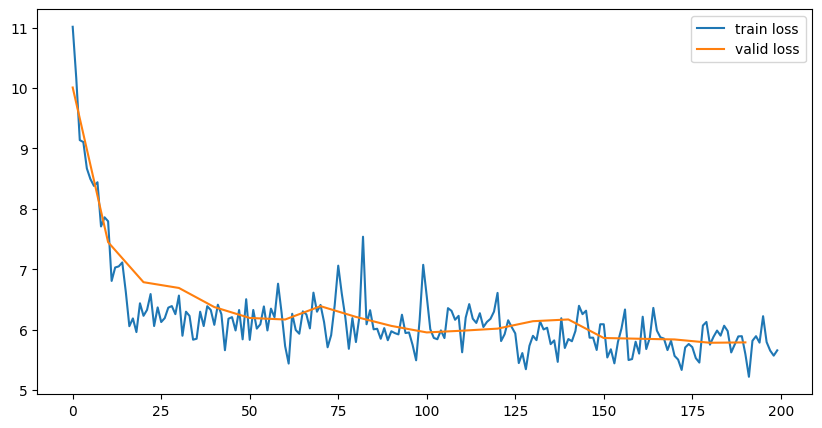

CPU times: user 21min 9s, sys: 6min 9s, total: 27min 18s
Wall time: 5min 23s


In [ ]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt

from time import time
from functools import partial

import logging
import warnings

from jaxpt.utils import append_to_csv


warnings.filterwarnings("ignore", message="Conversion for .*PmapSharding.*")
logging.getLogger("root").setLevel(logging.ERROR)

train_losses = []
val_losses = []
append_to_csv(log_dir / f"{run_dir}_train.csv", ["step", "lr", "loss", "norm", "time", "tokens_processed", "tokens_per_sec"])
append_to_csv(log_dir / f"{run_dir}_valid.csv", ["step", "loss"])

m.train()
try:
  for step in range(trconf.max_steps):
    start = time()
    batch, target = train_dl()
    avg_loss, avg_grads = parallel_train_step(m, optimizer, batch, target)
    #avg_loss, avg_grads = train_step(m, optimizer, batch, target)
    avg_loss.block_until_ready()
    # compute stats
    avg_loss = avg_loss[0]
    lr = warmup_with_cosine_decay_schedule(step)
    norm = 0 # norm[0]|
    iter_time = time() - start
    sub_step_time = iter_time / trconf.grad_accumulation_steps
    tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
    tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

    if step % trconf.print_interval == 0:
      train_losses.append((step, avg_loss))
      append_to_csv(log_dir / f"{run_dir}_train.csv", [step, lr, avg_loss, norm, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | loss: {avg_loss:0.4f} | norm: {norm:0.2f} | time: {iter_time*1000:0.2f}ms | tokens processed: {tokens_processed:,} | tok/sec: {tokens_per_sec:,.2f}")
    if step % trconf.eval_interval == 0:
      valid_loss, completions = evaluate(m)
      val_losses.append((step, valid_loss))
      append_to_csv(log_dir / f"{run_dir}_valid.csv", [step, valid_loss])
      print(f"valid loss: {valid_loss:0.4f}"  )
      for completion in completions:
        print(completion)
    if step % trconf.checkpoint_interval == 0:
      save_checkpoint(m, step)
    

except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")
valid_loss, completions = evaluate(m)
print(f"valid loss: {valid_loss:0.4f}")
print(f"completions: {completions}")
save_checkpoint(m, step)
for completion in completions:
  print(completion)
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.plot([x[0] for x in val_losses], [x[1] for x in val_losses], label="valid loss")
plt.legend()
plt.savefig(log_dir / f"{run_dir}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()